# Quadrature Phase Split test with FTDI
- https://www.silabs.com/documents/public/data-sheets/Si5351-B.pdf
- https://www.silabs.com/documents/public/application-notes/AN619.pdf 

In [8]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [9]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [10]:
paths = [['..', '..', '..', '..', '..', '..', '..', '已完成', 'Bridges', 'bitbucket', 'github', 'codes'], 
         ['..', '..', '..', '..', '..', '..', 'Utilities', 'bitbucket', 'github', 'codes'],
         ['..', '..', '..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [11]:
%pylab inline

from clock_generators.si5351 import Si5351
from utilities.adapters.peripherals import I2C

Populating the interactive namespace from numpy and matplotlib


## Limits of Si5351's phase-offset functionality
- constrain: CLKx_PHOFF has only 7 bits, and should be less than 128
- The higher the clock frequency, the greater phase offset possible.
- Even Freq_vco = **900MHz**, a clock with frequency greater than **28.235294MHz** (`360 / (127.5 * 360 /(900*4))`) can have 360 degree phase offset.
- If Freq_vco = **600MHz**, a clock with frequency greater than **18.823529MHz** (`360 / (127.5 * 360 /(600*4))`) can have 360 degree phase offset.
- Even Freq_vco = **900MHz**, a clock with frequency greater than **7.058823MHz** (`90 / (127.5 * 360 /(900*4))`) can have quadrature (90 degree) phase offset.
- If Freq_vco = **600MHz**, a clock with frequency greater than **4.705882MHz** (`90 / (127.5 * 360 /(600*4))`) can have quadrature (90 degree) phase offset.
- If we mess around and set Freq_vco = **100MHz**, a clock with frequency greater than **784.313KHz** (`90 / (127.5 * 360 /(100*4))`) can have quadrature (90 degree) phase offset.

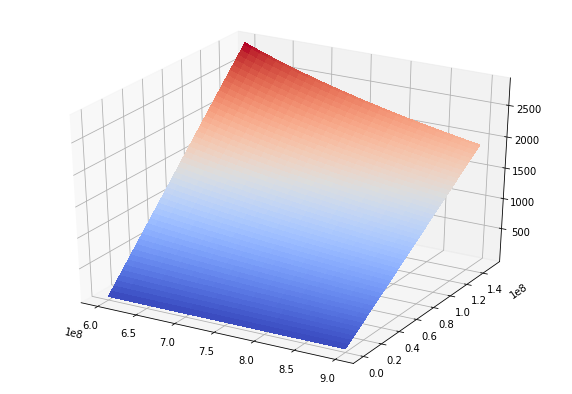

In [12]:
from mpl_toolkits.mplot3d import Axes3D 

freqs_vco = np.linspace(600e6, 900e6, 30) 
freqs_clock = np.linspace(2289, 150e6, 100) 

X = freqs_vco
Y = freqs_clock
X, Y = np.meshgrid(X, Y) 
Z = (Y * 127.5 * 360 / (X * 4))
# Z[ Z >360] = 360 
 
fig = plt.figure(figsize = (10, 7))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Debug mode?

In [13]:
cls = Si5351

cls.DEBUG_MODE_SHOW_BUS_DATA = False         # whether to show bus data. 
cls.DEBUG_MODE_PRINT_REGISTER = False        # whether to print registers. 

## Generators

In [14]:
with_hardware_device = False

if with_hardware_device:
    _i2c = I2C.get_Ftdi_i2c() 
    
else:
    _i2c =  None  # using None for testing without actual hardware device.

bus = I2C(_i2c)
si = cls(bus)   


****** Virtual device. Data may not be real ! ******



## Quadrature Phase Split

In [15]:
si.init()
si.enable(False)

I = si.clocks[0]
Q = si.clocks[1]

I.enable(True)
Q.enable(True)

In [16]:
# I.set_frequency(9e6)
# Q.set_frequency(9e6) 

In [17]:
si.plls['A'].set_frequency(600e6)
si.plls['A'].freq

600000000

In [18]:
freq = 4.71e6

I.set_frequency(freq)
Q.set_frequency(freq) 

True

In [19]:
Q.freq

4710000

my freq must be greater than 7.03e+06 to have 90 degree phase offset.

In [20]:
Q.set_phase(90)
Q.phase

89.7255

In [21]:
Q.set_phase(0)
Q.phase

0.0

In [22]:
si._write_element_by_name('CLK1_PHOFF', 0)
# si.multisynths[1].restore_frequency()
si.reset_plls()